In [1]:
import sys
sys.path.append('..')


In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os
from sklearn.model_selection import train_test_split

class PokemonPalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

data_dir: str = '../data/cropped/'
pokemon_dir: list[str] = [
    f"{data_dir}#Newポケモンスナップ/",
    f"{data_dir}ポケットモンスターシールド/"
]
pal_dir: list[str] = [
    f"{data_dir}/#パルワールド/", 
    f"{data_dir}/every-pal-in-palworld-a-complete-paldeck-list/",
    f"{data_dir}/paldex.io/"
]

pokemon_images: list[str] = [os.path.join(dir, file) for dir in pokemon_dir for file in os.listdir(dir)]
pal_images: list[str] = [os.path.join(dir, file) for dir in pal_dir for file in os.listdir(dir)]
total_images: list[str] = pokemon_images + pal_images
labels: list = [0] * len(pokemon_images) + [1] * len(pal_images)

# Split the dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(total_images, labels, test_size=0.2, random_state=42)

train_dataset = PokemonPalDataset(train_images, train_labels)
test_dataset = PokemonPalDataset(test_images, test_labels)


c:\Users\hiroga\miniconda3\envs\pokemon-pal\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total images: 510
Number of Pokemon images: 217
Number of Pal images: 293
Train dataset size: 408
Test dataset size: 102


c:\Users\hiroga\miniconda3\envs\pokemon-pal\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


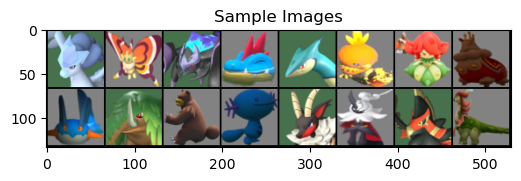

In [3]:
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Data Summary
print(f"Total images: {len(total_images)}")
print(f"Number of Pokemon images: {len(pokemon_images)}")
print(f"Number of Pal images: {len(pal_images)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Show a transformed image sample from the dataset
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Show images
train_dataset.transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

sample_indices = np.random.choice(len(train_dataset), 16)
sample_images = [train_dataset[i][0] for i in sample_indices]
out = torchvision.utils.make_grid(sample_images)
imshow(out, title="Sample Images")


Epoch 1: Train Loss = 3.8220481276512146, Test Loss = 0.587437127317701
Epoch 2: Train Loss = 0.5081665126176981, Test Loss = 0.5089225471019745
Epoch 3: Train Loss = 0.4286454440309451, Test Loss = 0.4975459745952061
Epoch 4: Train Loss = 0.3143955830198068, Test Loss = 0.6584883204528263
Epoch 5: Train Loss = 0.19077298818872526, Test Loss = 0.7826673814228603


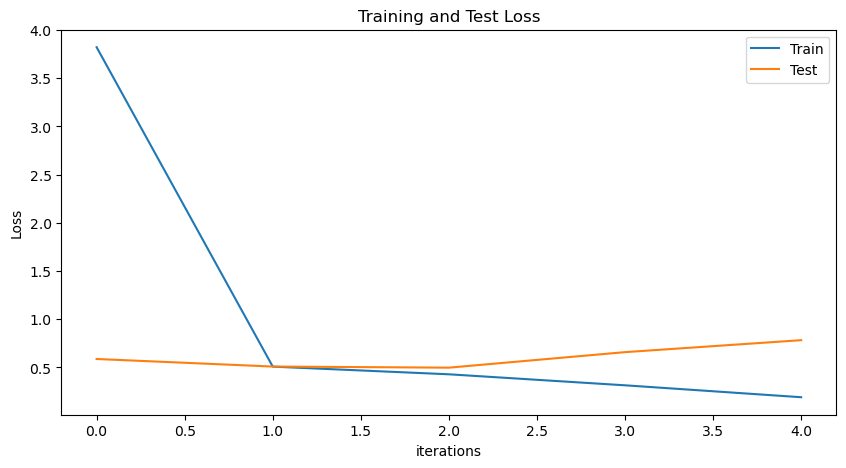

In [4]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.SimpleCNN import SimpleCNN
from safetensors.torch import save_file

# Training code
def train(model, optimizer, criterion, train_loader, test_loader, num_epochs, device):
    tensors = {}
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_test_loss = 0.0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(running_test_loss/len(test_loader))
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Test Loss = {test_losses[-1]}")
        
    # Save the model
    model_dir = '../models/'
    snapshots_dir = f"{model_dir}snapshots/"
    if not os.path.exists(snapshots_dir):
        os.makedirs(snapshots_dir)
    tensors = {name: param for name, param in model.named_parameters()}
    save_file(tensors, f"{snapshots_dir}SimpleCNN_{epoch+1}_{data_dir.replace('.', '').replace('/', '_')}_{image_size}x{image_size}.safetensors")
    save_file(tensors, f"{model_dir}model.safetensors")

    # Plotting the losses
    plt.figure(figsize=(10,5))
    plt.title("Training and Test Loss")
    plt.plot(train_losses,label="Train")
    plt.plot(test_losses,label="Test")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

image_size = 256

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(image_size=image_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])
train_dataset.transform = transform
test_dataset.transform = transform
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Fixing the batch size mismatch error
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs=5, device=device)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # print images
        for i in range(len(images)):
            imshow(images.cpu()[i])
            print('GroundTruth: ', labels[i])
            print('Output: ', outputs[i])

